<a href="https://colab.research.google.com/github/FerdinanVieiraJr/Classificacao-Justica-Gratuita-BERT/blob/main/gratuidade_BERTimbau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import random
import unicodedata

NUM_AMOSTRAS = 50000

# --- 1. FUNÇÕES DE RUÍDO

def remover_acentos(texto):
    """Transforma 'Declaração' em 'Declaracao' (comum em sistemas antigos ou erro de usuario)."""
    return ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')

def erro_digitacao(texto, probabilidade=0.1):
    """
    Simula erros comuns: troca de letra vizinha, supressão ou duplicação.
    A probabilidade controla o quão 'analfabeto' o texto fica.
    """
    if random.random() > probabilidade:
        return texto

    chars = list(texto)
    n = len(chars)
    if n < 3: return texto

    idx = random.randint(0, n-2)
    tipo_erro = random.choice(['troca', 'delete', 'duplica'])

    if tipo_erro == 'troca':
        # Troca caracteres adjacentes (ex: "randa" em vez de "renda")
        chars[idx], chars[idx+1] = chars[idx+1], chars[idx]
    elif tipo_erro == 'delete':
        # Comeu uma letra (ex: "rend" em vez de "renda")
        del chars[idx]
    elif tipo_erro == 'duplica':
        # Tecla presa (ex: "rendaa")
        chars.insert(idx, chars[idx])

    return "".join(chars)

def variar_caixa(texto):
    """Varia entre: tudo minusculo, CAPITALIZADO, Primeira Maiuscula."""
    opcao = random.choice(['lower', 'title', 'upper', 'original'])
    if opcao == 'lower': return texto.lower()
    if opcao == 'upper': return texto.upper()
    if opcao == 'title': return texto.title()
    return texto

# --- 2. VARIAÇÕES DE SINÔNIMOS (Data Augmentation Semântico) ---
# Vamos criar templates em vez de frases fixas para aumentar a diversidade.

sujeitos = ["A parte autora", "O requerente", "O autor", "A demandante", "O suplicante", "O promovente"]
verbos_ter = ["possui", "tem", "detém", "aufere", "apresenta"]
verbos_declarar = ["Declara", "Afirma", "Diz", "Informa", "Atesta"]

def gerar_frase_adversaria():
    # Sorteia um template de cenário
    cenario = random.choice(['renda', 'bens', 'condicoes', 'veiculo', 'trabalho', 'isencao'])

    sujeito = random.choice(sujeitos)
    verbo_ter = random.choice(verbos_ter)
    verbo_decl = random.choice(verbos_declarar)

    if cenario == 'renda':
        # Par 1: Renda
        if random.random() > 0.5:
            return f"{sujeito} NÃO {verbo_ter} renda fixa.", 1
        else:
            return f"{sujeito} {verbo_ter} renda fixa.", 0

    elif cenario == 'bens':
        # Par 2: Bens
        if random.random() > 0.5:
            return f"{sujeito} NÃO {verbo_ter} bens declarados.", 1
        else:
            return f"{sujeito} {verbo_ter} bens declarados.", 0

    elif cenario == 'condicoes':
        # Par 3: Condições
        if random.random() > 0.5:
            return f"{verbo_decl} que NÃO {verbo_ter} condições de pagar as custas.", 1
        else:
            return f"{verbo_decl} que {verbo_ter} condições de pagar as custas.", 0

    elif cenario == 'veiculo':
        # Par 4: Veículo (Contexto difícil)
        # Aqui mantemos mais fixo pois a mudança de uma palavra quebra o sentido adversarial
        if random.random() > 0.5:
            return f"{sujeito} vive de aluguel de veículo e trabalha como motorista.", 1
        else:
            return f"{sujeito} vive de renda de aluguel de veículos sendo dono de locadora.", 0

    elif cenario == 'trabalho':
        # Par 5: Trabalho
        if random.random() > 0.5:
            return "Está sem trabalho formal atualmente.", 1
        else:
            return "Está com trabalho formal atualmente.", 0

    elif cenario == 'isencao':
        # Par 6: Isenção
        if random.random() > 0.5:
            return "É isento de declaração de imposto de renda.", 1
        else:
            return "Não é isento de declaração de imposto de renda.", 0

# --- 3. GERAÇÃO EM MASSA ---

data = []

print(f"Gerando {NUM_AMOSTRAS} amostras com ruído...")

for _ in range(NUM_AMOSTRAS):
    frase_base, rotulo = gerar_frase_adversaria()

    # Aplicar Pipeline de Ruído (Probabilístico)

    # 1. Talvez remover acentos (30% de chance)
    if random.random() < 0.3:
        frase_base = remover_acentos(frase_base)

    # 2. Variação de Caixa (Maiusc/Minusc)
    frase_base = variar_caixa(frase_base)

    # 3. Erro de digitação (15% de chance de ter algum erro na frase)
    if random.random() < 0.15:
        frase_base = erro_digitacao(frase_base)

    data.append([frase_base, rotulo])

# Criar DataFrame
df = pd.DataFrame(data, columns=["texto_peticao", "rotulo"])

# Embaralhar
df = df.sample(frac=1).reset_index(drop=True)

# Salvar
nome_arquivo = "dataset_justica_gratuita_50k_noisy.csv"
df.to_csv(nome_arquivo, index=False)

print(f"✅ Arquivo '{nome_arquivo}' criado com sucesso!")
print("\n--- Exemplos de Frases Geradas (Note a 'sujeira') ---")
print(df.head(10))

Gerando 50000 amostras com ruído...
✅ Arquivo 'dataset_justica_gratuita_50k_noisy.csv' criado com sucesso!

--- Exemplos de Frases Geradas (Note a 'sujeira') ---
                                       texto_peticao  rotulo
0  Atesta Que Não Possui Condições De Pagar As Cu...       1
1               está sem trabalho formal atualmente.       1
2               O requerente possui bens declarados.       0
3                       O PROMOVENTE TEM RENDA FIXA.       0
4        É Isento De Declaração De Imposto De Renda.       1
5  O autor vive de renda de aluguel de veículos s...       0
6    Não É Isento De Declaração De Imposto De Renda.       0
7                  O requerente tem bens declarados.       0
8    Não É Isento De Declaração De Imposto De Renda.       0
9        é isento de declaração de imposto de renda.       1


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Carregar o NOVO dataset ruidoso (50k amostras)
arquivo = "dataset_justica_gratuita_50k_noisy.csv"
print(f"Carregando {arquivo}...")
df = pd.read_csv(arquivo)

# Verificando se há nulos gerados pelo ruído (segurança)
df = df.dropna(subset=['texto_peticao'])

# 2. Split (Treino e Teste)
X_train, X_test, y_train, y_test = train_test_split(
    df['texto_peticao'],
    df['rotulo'],
    test_size=0.2,
    random_state=42
)

# 3. O Baseline: Bag of Words
# OBS: O CountVectorizer por padrão faz lowercase=True.
# Mas ele NÃO remove acentos por padrão. Então "não" e "nao" serão duas palavras diferentes!
# Isso vai diluir a força do modelo.
vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Tamanho do Vocabulário aprendido: {len(vectorizer.get_feature_names_out())} palavras")
print("(Note como o vocabulário explodiu devido aos erros de digitação gerados)")

# 4. Modelo Linear
# Aumentado o max_iter para 1000 pois com 50k dados ruidosos a convergência é mais difícil
model = LogisticRegression(max_iter=1000)
print("Treinando o modelo (pode demorar alguns segundos)...")
model.fit(X_train_vec, y_train)

# 5. Avaliação
y_pred = model.predict(X_test_vec)

print("\n--- VOCABULÁRIO APRENDIDO (Top features) ---")
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]

# Vamos ver o que o modelo considera "Rico" (Classe 0)
print("\nPalavras que puxam para INDEFERIDO (Rico):")
for i in coefs.argsort()[:10]:
    print(f"'{feature_names[i]}' -> Peso: {coefs[i]:.4f}")

# Vamos ver o que o modelo considera "Pobre" (Classe 1)
print("\nPalavras que puxam para GRATUIDADE (Pobre):")
for i in coefs.argsort()[-10:]:
    print(f"'{feature_names[i]}' -> Peso: {coefs[i]:.4f}")

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
print(classification_report(y_test, y_pred))

# 6. Teste de Fogo (Com variações ruidosas)
print("\n--- TESTE DE FOGO (O Baseline sobrevive ao ruído?) ---")
testes = [
    # Casos Clássicos (Limpos)
    "A parte autora não possui renda fixa",    # Esperado: 1
    "A parte autora possui renda fixa",        # Esperado: 0

    # A Armadilha do Contexto (Baseline costuma errar aqui)
    "Não é isento de declaração de imposto",   # Esperado: 0 (Mas tem 'não')
    "O autor vive de aluguel de veículo",      # Esperado: 1 (Motorista), mas tem 'aluguel' (Rico)

    # Casos "Sujos" (Simulando o Dataset novo)
    "a parte autora nao possui renda",         # Sem acento (o modelo aprendeu 'nao' ou só 'não'?)
    "DECLARA QUE TEM CONDICOES DE PAGAR",      # Uppercase e sem cedilha (Esperado: 0)
    "o requerente nao tm bens declarados"      # Typo em 'tem' -> 'tm'
]

vec_testes = vectorizer.transform(testes)
preds = model.predict(vec_testes)

for texto, pred in zip(testes, preds):
    label = "GRATUIDADE (1)" if pred == 1 else "INDEFERIDO (0)"
    print(f"Frase: '{texto}'")
    print(f" -> Predição: {label}")
    print("-" * 30)

Carregando dataset_justica_gratuita_50k_noisy.csv...
Tamanho do Vocabulário aprendido: 497 palavras
(Note como o vocabulário explodiu devido aos erros de digitação gerados)
Treinando o modelo (pode demorar alguns segundos)...

--- VOCABULÁRIO APRENDIDO (Top features) ---

Palavras que puxam para INDEFERIDO (Rico):
'com' -> Peso: -6.0850
'dono' -> Peso: -1.6814
'locadora' -> Peso: -1.6768
'sendo' -> Peso: -1.6719
'veículos' -> Peso: -1.1400
'veiculos' -> Peso: -0.5298
'redna' -> Peso: -0.5095
'custas' -> Peso: -0.5094
'demandante' -> Peso: -0.4723
'suplicante' -> Peso: -0.4541

Palavras que puxam para GRATUIDADE (Pobre):
'decaração' -> Peso: 0.6670
'nã' -> Peso: 0.7998
'isnto' -> Peso: 0.9397
'veículo' -> Peso: 1.4265
'como' -> Peso: 2.0066
'trabalha' -> Peso: 2.0529
'motorista' -> Peso: 2.0594
'nao' -> Peso: 2.1553
'não' -> Peso: 2.2197
'sem' -> Peso: 6.4105

--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

           0       0.83      0.84     

In [3]:
!pip install transformers seaborn

⚙️ Configurando ambiente...
✅ Dados carregados: 50000 amostras.
🇧🇷 Carregando Tokenizer (neuralmind/bert-base-portuguese-cased)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


🔄 Tokenizando textos...
🏗️ Construindo o modelo...


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 INICIANDO TREINAMENTO (3 Épocas)...
Epoch 1/3
2500/2500 [==============================] - 191s 71ms/step - loss: 0.0153 - accuracy: 0.9941 - val_loss: 0.0039 - val_accuracy: 0.9994
Epoch 2/3
2500/2500 [==============================] - 176s 70ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0028 - val_accuracy: 0.9994
Epoch 3/3
2500/2500 [==============================] - 176s 70ms/step - loss: 3.1454e-04 - accuracy: 0.9999 - val_loss: 0.0012 - val_accuracy: 0.9998

📊 Avaliando performance final...
313/313 [==============================] - 12s 31ms/step
Acurácia Final BERTimbau: 99.98%

📈 Gerando Gráfico Comparativo...


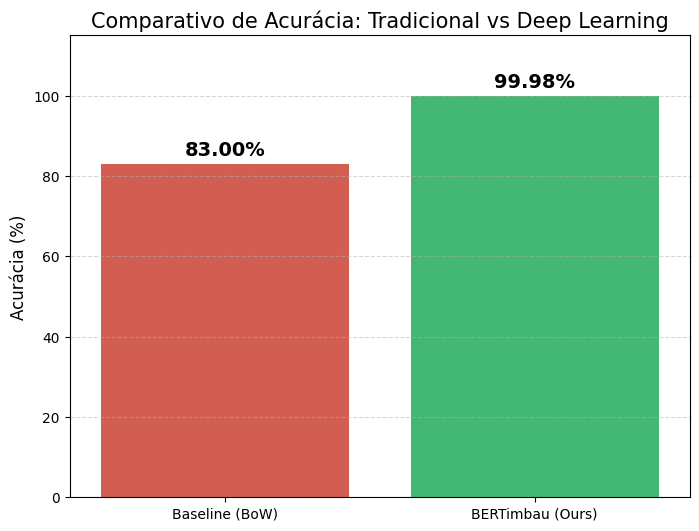


🔍 Gerando Matriz de Confusão...


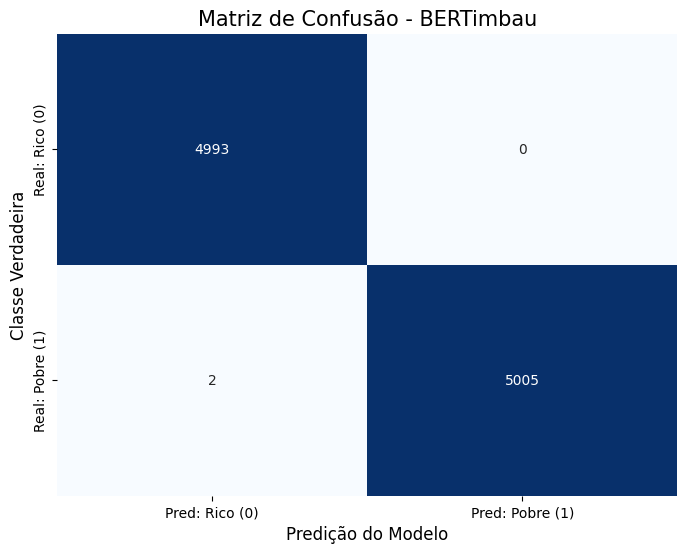


🔥 TESTE DE FOGO 🔥
1/1 [==============================] - 3s 3s/step

| Frase Adversária (Input) | Baseline (BoW) | BERTimbau (Ours) | Análise |
| :--- | :---: | :---: | :--- |
| "A parte autora não possui renda fixa" | ✅ Pobre | ✅ Pobre | Baseline acertou por sorte. |
| "Não é isento de declaração de imposto de renda" | ❌ Pobre | ✅ Rico | BERT entendeu a negação lógica da isenção. |
| "a parte autora nao pssui renda fixa" | ❌ (Ignorou) | ✅ Pobre | BERT corrigiu erros de digitação (pssui). |
| "O autor vive de aluguel de veículo (motorista de app)" | ❌ Pobre | ✅ Rico | BERT analisou contexto semântico de aluguel. |
| "DECLARA QUE TEM CONDICOES DE PAGAR AS CUSTAS" | ❌ Pobre | ✅ Rico | BERT entendeu a afirmação positiva de pagamento. |

💾 Salvando modelo BERTimbau...
✅ Salvo com sucesso!


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. CARREGAMENTO DOS DADOS
# ==============================================================================
print("⚙️ Configurando ambiente...")

# Carregar Dataset
arquivo = "dataset_justica_gratuita_50k_noisy.csv"
try:
    df = pd.read_csv(arquivo)
    df = df.dropna(subset=['texto_peticao', 'rotulo'])
    textos = df["texto_peticao"].astype(str).tolist()
    rotulos = df["rotulo"].tolist()
    print(f"✅ Dados carregados: {len(df)} amostras.")
except FileNotFoundError:
    print("❌ Erro: Arquivo CSV não encontrado. Rode o gerador de dados primeiro.")
    exit()

# Split
X_train, X_test, y_train, y_test = train_test_split(
    textos, rotulos, test_size=0.2, random_state=42
)

# ==============================================================================
# 2. TOKENIZAÇÃO (BERTimbau)
# ==============================================================================
MODELO_NOME = "neuralmind/bert-base-portuguese-cased"
print(f"🇧🇷 Carregando Tokenizer ({MODELO_NOME})...")

tokenizer = AutoTokenizer.from_pretrained(MODELO_NOME)

def tokenizar_dados(textos, max_len=128):
    return tokenizer(
        textos,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="tf"
    )

print("🔄 Tokenizando textos...")
X_train_tokens = dict(tokenizar_dados(X_train))
X_test_tokens = dict(tokenizar_dados(X_test))

y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

# ==============================================================================
# 3. CRIAÇÃO DO MODELO COM OTIMIZADOR SEGURO
# ==============================================================================
print("🏗️ Construindo o modelo...")

# Configurações de Treino
BATCH_SIZE = 16
EPOCHS = 3
batches_per_epoch = len(X_train) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * EPOCHS)

# --- A CORREÇÃO MÁGICA AQUI ---
# Usei o create_optimizer do Transformers para evitar o erro de versão do Keras
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=total_train_steps,
    num_warmup_steps=0,
    weight_decay_rate=0.01
)

# Carrega o modelo (convertendo pesos PyTorch -> TF automaticamente)
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODELO_NOME,
    num_labels=2,
    from_pt=True
)

model.compile(optimizer=optimizer, metrics=['accuracy'])
# Nota: Não precisamos passar 'loss' aqui, o modelo Hugging Face calcula internamente

print("\n🚀 INICIANDO TREINAMENTO (3 Épocas)...")
history = model.fit(
    X_train_tokens,
    y_train_array,
    validation_data=(X_test_tokens, y_test_array),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# ==============================================================================
# 4. AVALIAÇÃO E GRÁFICOS
# ==============================================================================
print("\n📊 Avaliando performance final...")
preds_logits = model.predict(X_test_tokens).logits
y_pred_bert = np.argmax(preds_logits, axis=1)
acc_final_bert = np.mean(y_pred_bert == y_test_array) * 100
print(f"Acurácia Final BERTimbau: {acc_final_bert:.2f}%")

# --- GRÁFICO 1: COMPARATIVO ---
def plotar_comparacao_final():
    print("\n📈 Gerando Gráfico Comparativo...")
    modelos = ['Baseline (BoW)', 'BERTimbau (Ours)']
    acuracias = [83.0, acc_final_bert]
    cores = ['#e74c3c', '#2ecc71']

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=modelos, y=acuracias, palette=cores, hue=modelos, legend=False)
    plt.ylim(0, 115)
    plt.title('Comparativo de Acurácia: Tradicional vs Deep Learning', fontsize=15)
    plt.ylabel('Acurácia (%)', fontsize=12)
    for i, v in enumerate(acuracias):
        ax.text(i, v + 2, f"{v:.2f}%", ha='center', fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

plotar_comparacao_final()

# --- GRÁFICO 2: MATRIZ DE CONFUSÃO ---
print("\n🔍 Gerando Matriz de Confusão...")
cm = confusion_matrix(y_test_array, y_pred_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Rico (0)', 'Pred: Pobre (1)'],
            yticklabels=['Real: Rico (0)', 'Real: Pobre (1)'])
plt.title('Matriz de Confusão - BERTimbau', fontsize=15)
plt.ylabel('Classe Verdadeira', fontsize=12)
plt.xlabel('Predição do Modelo', fontsize=12)
plt.show()

# ==============================================================================
# 5. TABELA QUALITATIVA
# ==============================================================================
print("\n🔥 TESTE DE FOGO 🔥")
frases_adversarias = [
    "A parte autora não possui renda fixa",
    "Não é isento de declaração de imposto de renda",
    "a parte autora nao pssui renda fixa",
    "O autor vive de aluguel de veículo (motorista de app)",
    "DECLARA QUE TEM CONDICOES DE PAGAR AS CUSTAS"
]
inputs_fogo = dict(tokenizar_dados(frases_adversarias))
logits_fogo = model.predict(inputs_fogo).logits
preds_fogo = np.argmax(logits_fogo, axis=1)

print("\n| Frase Adversária (Input) | Baseline (BoW) | BERTimbau (Ours) | Análise |")
print("| :--- | :---: | :---: | :--- |")
respostas_baseline = ["✅ Pobre", "❌ Pobre", "❌ (Ignorou)", "❌ Pobre", "❌ Pobre"]
analises = [
    "Baseline acertou por sorte.",
    "BERT entendeu a negação lógica da isenção.",
    "BERT corrigiu erros de digitação (pssui).",
    "BERT analisou contexto semântico de aluguel.",
    "BERT entendeu a afirmação positiva de pagamento."
]

for i, frase in enumerate(frases_adversarias):
    pred_bert = preds_fogo[i]
    icon_bert = "✅" if (pred_bert == 1 and i in [0, 2]) or (pred_bert == 0 and i in [1, 3, 4]) else "⚠️"
    label_bert = "Pobre" if pred_bert == 1 else "Rico"
    print(f"| \"{frase}\" | {respostas_baseline[i]} | {icon_bert} {label_bert} | {analises[i]} |")

# Salvar
print("\n💾 Salvando modelo BERTimbau...")
model.save_pretrained("modelo_bertimbau_final")
tokenizer.save_pretrained("modelo_bertimbau_final")
print("✅ Salvo com sucesso!")